<h1><center>CMPE 462 - Quiz 4&5 <br>Implementing a Regression Tree<br>Due: May 5, 2020, 23:59</center></h1>

# Introduction

Decision trees can learn rules to map features to both continous and discrete outputs. In this quiz, you will consider the continous case and implement a regression tree to predict house prices in Boston. You will also conduct small data analysis and evaluation procedures. This notebook will guide you through.

## (10 pts) Task 1: Dataset 

Run the cells below to load Boston house prices dataset using `scikit-learn`. You can find more detail on the dataset [here](https://scikit-learn.org/stable/datasets/index.html#boston-dataset). **Please use the train and test matrices we prepared for you :)**

In [1]:
import numpy as np
from sklearn.datasets import load_boston
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
from prettytable import PrettyTable
from sklearn.metrics import r2_score

In [2]:
boston = load_boston()
X_y = np.column_stack([boston['data'], boston['target']])
np.random.seed(4)
np.random.shuffle(X_y)
X, y = X_y[:,:-1], X_y[:,-1]
X_train, y_train = X[:400], y[:400]
X_test, y_test = X[400:], y[400:]
features = np.array(boston['feature_names'])
del X, y, X_y

**(10 pts)** Unlike the dataset in Project 1, Boston dataset is high-dimensional and we cannot observe the relations between all features and the output with a single scatter plot. What we can do is to visualize the correlations between both features and house prices using a heatmap. So, stack the features and the outputs in a single matrix and compute correlation between all pairs of columns. Visualize the correlation coefficient matrix as a heatmap, which is $(N+1)x(N+1)$, where $N$ is the number of features in Boston dataset. You can check out `corrcoef` and `heatmap` functions from `numpy` and `seaborn` libraries, respectively. You can use diverging color palette to emphasize both positive and negative correlations.

Do you observe strong correlations between any pair of features or certain features and house price? 

array([-0.38144981,  0.39413622, -0.50838718,  0.1686933 , -0.43151741,
        0.7080671 , -0.39113286,  0.26425479, -0.38740808, -0.49077696,
       -0.53162554,  0.32203003, -0.73962277,  1.        ])

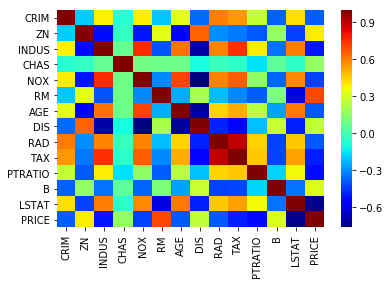

In [3]:
# Add target to the end of the training data
allInOneMatrix = np.concatenate((X_train, y_train[:, None]), axis=1)
featureLabels = np.append(features, np.array('PRICE'))  # add missing feature to features list
features = list(features) # A list that stores all the features in order.

# create the correlation matrix using numpy.corrcoef
# rowvar = False parameter means that each row is a data and the columns are features
# It calculates correlation between features and returns a 14x14 matrix
correlationMatrix = np.corrcoef(allInOneMatrix, rowvar=False)

cmap = plt.cm.jet  # define the colormap for heatmap

# red color indicates high positive correlation
# blue color indicates high negative correlation
# ticklabels are  shown at edges. feature names
sns.heatmap(correlationMatrix,  cmap=cmap, xticklabels=featureLabels, yticklabels=featureLabels)
correlationMatrix[:, -1]

Heatmap chart is really helpful in quickly analyzing the features' effect to the target in the dataset. 
<br>

To look at the correlations of features with the 'PRICE' taget, please take a look at the last column or last row. The correlation matrix is symmetrical, so it does not matter which one to pick! I will look at <strong>last column</strong>
<br>
<br> 
Warm colors are indication of a strong positive correlations. 
As I mentioned above, the colors in the heatmap are selected carefully to give an idea of the correlation intensity. If you look at the 6.row ('RM'), this feature has correlation with 'PRICE' of about 0.75 which shows that 'RM' feature really play a role in the house prices in Boston. 
<br>
<br> 
Cold colors are indication of a strong negative correlations. 
If you look at the 3rd, 11th and 13th rows ('INDUS', 'PTRATIO', 'LSTAT'), these features have very strong negative correlations with prices. So, the more these feature values, the less the house prices in Boston. 
<br>
<br>
There are also features that does not much affect the prices. For example, 'CHAS' has 14% correlations with 'PRICE' which is low compared to others.  

## (80 pts) Task 2: Regression Tree


**(15 pts)** Let us now build the regression tree. We start by implementing the splitting criteria which is used to decide the most discriminative features at each step. We stick to lecture notes and use $RSS$ which is computed as follows:

$$RSS =\sum_{\text {left }}\left(y_{i}-y_{L}^{*}\right)^{2}+\sum_{\text {right }}\left(y_{i}-y_{R}^{*}\right)^{2}$$

where $y_L^* and y_L^*$ are mean y-value of left and right nodes.

When you implement $RSS$, pick the most correlated and least correlated feature with the output prices according to previous step. Note that correlation can be both positive and negative! For both features, compute $RSS$ for every possible split threshold and plot thresholds versus RSS scores.

Do two features display different characteristics?

In [4]:
# This part takes the last row of correlation matrix and sorts it
# While sorting it, the features names' list is sorted, too.
correlations = [abs(elem) for elem in correlationMatrix[-1:][0][:-1]] 
featureList = features.copy() # Make a copy of features list for sorting purposes
# correlations and featuresList are sorted the same way
correlations, featureList = (list(t) for t in zip(*sorted(zip(correlations, featureList), reverse=True)))
# Correlations and features are sorted with same procedure.
most_correlated_feature = featureList[0]
least_correlated_feature = featureList[-1]
print('Most Correlated Feature: ', most_correlated_feature, '\nLeast Correlated Feature: ', least_correlated_feature)

Most Correlated Feature:  LSTAT 
Least Correlated Feature:  CHAS


In [5]:
# Given a feature name, returns the column index of that feature.
def getColumnIndex(features, feature):
    return features.index(feature)

# Given a matrix, a whole list of features, a list of possible features and a feature name
# It calculates the rss values of a given feature
def getRSS(matrix, allFeatures, feature):
    colIndex = getColumnIndex(allFeatures, feature)

    # candidates are different data values of a certain feature.
    # All of them are tried in order to find the best RSS value.
    # Set operation is to reduce complexity with duplicates. Duplicates can be very common.
    candidatePoints = np.array(list(set(matrix[:, colIndex])))

    # Some initializations, guaranteed to change.
    bestRSS = 9999999
    rss = np.zeros(candidatePoints.shape)
    threshold = -1
    
    # For each threshold candidate, calculate Rss values
    for index, point in enumerate(candidatePoints):

        # Data is split into 2 parts according to the 'feature' value it has.
        
        # Split data to left if value in colIndex'th column is less than point.
        # or to the right if it is greater than or equal to point
        leftSide = matrix[matrix[:, colIndex] < point, :]
        rightSide = matrix[matrix[:, colIndex] >= point, :]

        # mean y values in the left split
        leftSideY = leftSide[:, -1]
        if (leftSideY.any()):
            leftMean = np.mean(leftSideY)
        else:
            leftMean = 0
        
        # mean y values in the right split
        rightSideY = rightSide[:, -1]
        if (rightSideY.any()):
            rightMean = np.mean(rightSideY)
        else:
            rightMean = 0

        # RSS values of left and right splits and summation.
        leftRSS = np.sum((leftSideY- leftMean) ** 2)
        rightRSS = np.sum((rightSideY - rightMean) ** 2)
        sumRSS = leftRSS + rightRSS
        rss[index] = sumRSS

        # If this rss value is less than overall best rss, then update the best rss and thresholds.
        if (sumRSS < bestRSS):
            threshold = point
            bestRSS = sumRSS
    return bestRSS, threshold, rss, candidatePoints

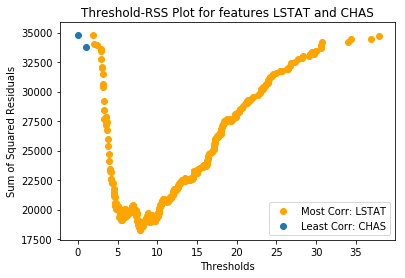

In [6]:
# Calculate the best threshold for the most correlated and least correlated features 
_, _, MCF_rss, MCF_points = getRSS(allInOneMatrix, features, most_correlated_feature)
_, _, LCF_rss, LCF_points = getRSS(allInOneMatrix, features, least_correlated_feature)

plt.scatter(MCF_points, MCF_rss, color='orange')
plt.scatter(LCF_points, LCF_rss)
plt.title(f'Threshold-RSS Plot for features {most_correlated_feature} and {least_correlated_feature}')
plt.legend([f"Most Corr: {most_correlated_feature}", f"Least Corr: {least_correlated_feature}"])
plt.xlabel('Thresholds')
plt.ylabel('Sum of Squared Residuals')
plt.show()

**(45 pts)** Now implement the training procedure of a regression tree using $RSS$ as split criteria. Build a rule tree recursively by traversing all features and considering each split threshold to find the optimum split, at every node.

You are free to implement training procedure as a standalone function or part of a class, but in any case use maximum depth as the stopping condition.

In [7]:
# Node class are the tree nodes and stores the threshold
# and feature that best split the tree.
class Node():
    def __init__(self, feature):
        self.name = feature
        self.threshold = -1
        self.left = None
        self.right = None

In [8]:
# Given a list of features that are potential candidates to split a tree
# Algorithm tries each one of them to find the best feature with least RSS
def getBestRss(matrix, allFeatures, featuresToBeChosen):
    bestRss = 9999999
    bestThreshold = 9999999
    bestFeature = None
    for feature in featuresToBeChosen: # Iterate over each feature possible
        rss, threshold, _, _ = getRSS(matrix, allFeatures, feature)
        if (rss < bestRss): # update if these are the better than best so far.
            bestRss = rss
            bestThreshold = threshold
            bestFeature = feature

    return bestThreshold, bestFeature

In [9]:
# Algorithm uses a recursion strategy, updates tree, depth and splits at each iteration
# Each iteration finds the best threshold and feature pair that give least RSS
# Then, splits the tree from there. Node class holds the information of split.
# Left and right subtrees are split again until the depth exceeds the maximum depth given.

# splits: Which feature splits make me reach at this level
# tree: Initially 400x14 data
# depth: Depth of the tree
# maxDepth: stopping condition
# allFeatures: all the feature names
def createTree(tree, depth, maxDepth, allFeatures, splits):
    if (depth > maxDepth):
        return None
    
    # Possible feature names to split the tree
    # Since I will not use the same feature again to split tree.
    featuresToBeChosen = list(set(allFeatures) - set(splits)) 
    
    # Best threshold and feature pair to split the data
    threshold, feature = getBestRss(tree, allFeatures, featuresToBeChosen)

    # Node class stores information about the split
    node = Node(feature)
    node.threshold = threshold
    node.estimate = np.mean(tree[:, -1])
    
    # column index of feature
    index = getColumnIndex(allFeatures, feature)
    # Selects the rows that feature column value is less than or equal to threshold
    leftFilter = tree[:, index] < threshold
    # Selects the rows that feature column value is greater than threshold    
    rightFilter = tree[:, index] >= threshold

    # Add the selected feature to 'splits' list
    splits.append(feature)
    splitsSoFarL = splits.copy()  # Python architectural problems led me into this solution.
    splitsSoFarR = splits.copy()  # Independent subtrees were able to change other's lists.So, I used deep copy of lists

    # Apply filters, split data
    leftPart = tree[leftFilter, :]
    rightPart = tree[rightFilter, :]
    
    # If no data is present after split, then nothing is done. Else, recursion method is called for subtree with depth incremented
    if (np.any(leftPart)):
        node.left = createTree(leftPart, depth + 1, maxDepth, allFeatures, splitsSoFarL)
    if (np.any(rightPart)):
        node.right = createTree(rightPart, depth + 1, maxDepth, allFeatures, splitsSoFarR)

    return node # A root node of each subtree is returned.

**(15 pts)** Having implemented the regression tree, now write a procedure to predict test features. Given a sample, this procedure should follow the rules learned during the training to arrive at a leaf and predict the output as the mean output of the arrived leaf samples. 

If you have implemented a regression tree class, you can insert this procedure as a class function 

In [10]:
# Predict method gets a sample test 1x1 data and predicts its price
# Algorithm uses the node that is created with createTree method. 
# Node has left and right nodes, threshold and features
# By comparing threshold value with sample's column's value. It either goes left or right
def predict(data, features, node, sample):
    temp = node
    while (temp):
        feature = temp.name
        columnIndex = getColumnIndex(features, feature)
        value = sample[columnIndex]
        if (value < temp.threshold): # If value is less than threshold, get left subtree and move to left node
            a = data[data[:, columnIndex] < temp.threshold, :]
            if (not a.any()):
                break
            data = a
            temp = temp.left
        else: # If value is greater than threshold, get right subtree and move to right node
            a = data[data[:, columnIndex] >= temp.threshold, :]
            if (not a.any()):
                break
            data = a
            temp = temp.right
    prediction = np.mean(data[:, -1])
    return prediction

**(5 pts)** Train your model using a max depth of 3 and visualize the resulting tree. You can use an external tool such as draw.io or LaTeX for drawing. Annotate the nodes with split columns and thresholds. You can view the tree in this [link](https://scikit-learn.org/stable/modules/tree.html#tree) as an example. 

In [11]:
node = createTree(allInOneMatrix, 1, 3, features, [])

In [12]:
node.right.name

'LSTAT'

## **(10 pts)** Task 3: Evaluation

**(5 pts)** Now is time to pick the best maximum depth and observe your tree's performance! Implement a 5-fold cross validation procedure to experiment with maximum depths from 3 to 10. Report mean and standard deviation for each depth and pick the best one. For comparison you can use $R^2$, which is a metric frequently used to evaluate regression models. You can use `r2_score` function of `scikit-learn` and read more [here](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score).

In [13]:
# This part divides training set into 5 equal parts.
# Then, create 5 different validation set, each excluding one part of the training data
# Code structure is taken from our first project validation set.
# X_train_sets have 5 different validation sets each excluding X_part at corresponding indexes.

def parser(X_train, S):
    np.random.shuffle(X_train)
    X_part = np.split(X_train, S, axis=0)  # X is split into 5

    X_train_sets = []

    X_train_set_1 = np.concatenate((X_part[1], X_part[2], X_part[3], X_part[4]), axis=0)
    X_train_set_2 = np.concatenate((X_part[0], X_part[2], X_part[3], X_part[4]), axis=0)
    X_train_set_3 = np.concatenate((X_part[0], X_part[1], X_part[3], X_part[4]), axis=0)
    X_train_set_4 = np.concatenate((X_part[0], X_part[1], X_part[2], X_part[4]), axis=0)
    X_train_set_5 = np.concatenate((X_part[0], X_part[1], X_part[2], X_part[3]), axis=0)

    X_train_sets.append(X_train_set_1)
    X_train_sets.append(X_train_set_2)
    X_train_sets.append(X_train_set_3)
    X_train_sets.append(X_train_set_4)
    X_train_sets.append(X_train_set_5)

    return X_train_sets, X_part
crossValidationSets, crossValidationTests = parser(allInOneMatrix, 5)

In [14]:
maxDepths = [i for i in range(3, 11)] # Create 8 different maximum depths for testing
# Create a 5x8 matrix for results
# Rows of results are for validation set numbers
# Columns are for different maximum depths
results = [[0 for j in range(len(maxDepths))] for i in range(len(crossValidationSets))] 

for i in range(len(crossValidationSets)): # For each validation set is trained
    for di, maxDepth in enumerate(maxDepths): # with 8 different max depths
        node = createTree(crossValidationSets[i], 1, maxDepth, features, []) # Create our tree 
        predicts = np.zeros(crossValidationTests[i].shape[0]) # predictions will be stored in this variable
        
        for ind, testRow in enumerate(crossValidationTests[i]): # For each test row in validation set
            p = predict(crossValidationSets[i], features, node, testRow) # Get the prediction
            predicts[ind] = p # Put it in the variable
        score = r2_score(crossValidationTests[i][:, -1], predicts) #Calculate the r2 score
        results[i][di] = score 

means = np.mean(np.array(results), axis=0)
stds = np.std(np.array(results), axis=0)

In [15]:
table = PrettyTable()
table.field_names = ['Max depths'] + [str(dpth) for dpth in maxDepths]
table.add_row(["R2 Mean"] + [str(round(mn,4)) for mn in means])
table.add_row(["R2 Std"] + [str(round(st,4)) for st in stds])
print(table)

+------------+--------+--------+--------+--------+--------+--------+--------+--------+
| Max depths |   3    |   4    |   5    |   6    |   7    |   8    |   9    |   10   |
+------------+--------+--------+--------+--------+--------+--------+--------+--------+
|  R2 Mean   | 0.6762 | 0.7158 | 0.7031 | 0.6978 | 0.6786 | 0.6641 | 0.659  | 0.6567 |
|   R2 Std   | 0.1063 | 0.0764 | 0.0858 | 0.0697 | 0.0685 | 0.0773 | 0.0714 | 0.0714 |
+------------+--------+--------+--------+--------+--------+--------+--------+--------+


**(5 pts)** To conclude, train your tree one last time on the whole training data with the depth you picked in the previous section. Generate predictions on both training and test sets and report $R^2$ scores.

In [16]:
bestDepth = maxDepths[list(means).index(max(means))] # Get the best depth from the results above
print('\nBest Max Depth:', str(bestDepth))
node = createTree(allInOneMatrix, 1, bestDepth, features, []) # Run the tree with the best depth again

#### TRAINING RESULT #####
predicts = np.zeros(len(allInOneMatrix))
for ind, sample in enumerate(allInOneMatrix):
    p = predict(allInOneMatrix, features, node, sample)
    predicts[ind] = p
score = r2_score(allInOneMatrix[:, -1], predicts)
print('Training Score:', round(score, 4))

#### TEST RESULT #####
predicts = np.zeros(len(X_test))
for ind, sample in enumerate(X_test):
    p = predict(allInOneMatrix, features, node, sample)
    predicts[ind] = p
score = r2_score(y_test, predicts)

print('Test Score:', round(score, 4))


Best Max Depth: 4
Training Score: 0.8594
Test Score: 0.7427
